# Get and explore dataset

In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import re

In [2]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [3]:
negative_file = "negative.txt"
positive_file = "positive.txt"

In [4]:
# Do not modify - helper function to load and preprocess data
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [5]:
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [6]:
# Do not modify - Combines the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)

from tensorflow.keras import utils as np_utils
labels  = np_utils.to_categorical(to_numeric_label(word_labels))


The mean review size of the dataset is 24.676519799219186 characters per review.
Standard deviation of dataset is : 11.284051928842775


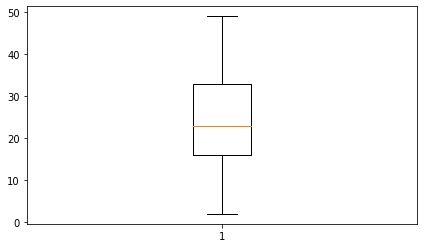

The number of unique words in the dataset is 1676 words.


In [49]:
# Write some code to investigate the dataset. 
# - Calculate and report the mean review size, its standard deviation and create a boxplot.
# - Calculate the number of unique words in the dataset
# - Perform any other dataset investigation that you feel would be valuable

# **********************************************************************************************

# - Calculate and report the mean review size

# Determine total characters make up each string
c = [len(i) for i in data]
mean = sum(c) / len(c)
print("The mean review size of the dataset is", mean, "characters per review.")

# - Calculate and report standard deviation
variance = sum([((x - mean) ** 2) for x in c]) / len(c)
res = variance ** 0.5
print("Standard deviation of dataset is : " + str(res))

# - Create boxplot
fig = plt.figure(figsize =(7, 4))

# Creating plot
plt.boxplot(c)
# show plot
plt.show()

# Calculate no. unique words. 
unique = set(data)
no_unique_words = len(unique)
print("The number of unique words in the dataset is",no_unique_words, "words.")


In [50]:
# Do not modify - Tokenize the vocabulary 
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25)

tokenizer.fit_on_texts(data) #create the vocabularry

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

# Compare a sample of the data before and after tokenization
print(data[10:20])
print(tokenized_data[10:20])

['eye opening information', 'a gem', 'the best book on money ive ever read', 'funny sexy sweet poignant', 'one of koontzs better books', 'absolutely fantastic', 'possible side effects a burroughs', 'a dream a vision the west incarnate', 'loved it', 'as expected']
[[], [1], [2, 19, 3, 23, 14], [], [18, 4], [], [1], [1, 1, 2], [13], []]


# Pre-processing

In [51]:
# Pre-processing
# Write some code to pre-process the data so that each review is the same length

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad the training sequences
pad_type = 'post'
trunc_type = 'post'
train_padded = pad_sequences(tokenized_data, padding=pad_type, truncating=trunc_type, maxlen=4)

print(train_padded)

[[18  4  2 19]
 [ 2  4  2  0]
 [ 0  0  0  0]
 ...
 [ 0  0  0  0]
 [ 6  0  0  0]
 [ 0  0  0  0]]


In [52]:
# Write some code to split the data into a training and test set. Make sure you shuffle the data. Use 20% for the test set.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_padded, 
                labels, test_size=0.20, shuffle = True, random_state = 0)



In [53]:
# Fill in the following function so it
# - makes a prediction for the test set given the model
# - reports the precision, recall and f1 score. Also print the confusion matrix. 
# You will need to use the helper to_class function to convert y_pred and y_test before supplying them to the sklearn functions.

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report

def assess_model(model, X_test, y_test):     
    
    # Make a prediction for the test set given the model
    y_pred = model.predict(X_test)
       
    # Convert back to class form from categorical form.

    y_pred = to_class(y_pred)
    y_test = to_class(y_test)
    
    # Calculate precision, recall and f1-score.
    print(classification_report(y_test, y_pred))

    # Get multilabel Confusion Matrix
    mcm = multilabel_confusion_matrix(y_test, y_pred, labels = y_test)
    print("\nCONFUSION MATRIX:\n", mcm)  
   


# Build and tune model

Define network architecture

In [54]:
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Create a sequential model
model = Sequential()

# Create a embedding layer
model.add(tf.keras.layers.Embedding(5000, 20, input_length=4))

# Create SpacialDropout layer
model.add(tf.keras.layers.SpatialDropout1D(0.2))

# Create Batch Normaliszation layer
model.add(BatchNormalization())

# Create a LSTM layer
look_back = 1
model.add(LSTM(32,input_shape=(1,look_back)))  

# Create a Dense layer
model.add(Dense(2, activation = 'softmax')) 


Train model 

In [55]:
# Loop various batch sizes and get accuracy/loss values. 
batch_size_list = [10,25,50,100]

for i in (batch_size_list):
    # Train
    print("BATCH SIZE = ", i)
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 5, batch_size = i, shuffle = True)
    print("**************************************************************************************************")


BATCH SIZE =  10
Epoch 1/5
144/144 [==============================] - 8s 17ms/step - loss: 0.6853 - accuracy: 0.5593 - val_loss: 0.6888 - val_accuracy: 0.5460
Epoch 2/5
144/144 [==============================] - 1s 10ms/step - loss: 0.6622 - accuracy: 0.6067 - val_loss: 0.6744 - val_accuracy: 0.5877
Epoch 3/5
144/144 [==============================] - 1s 10ms/step - loss: 0.6474 - accuracy: 0.6004 - val_loss: 0.6578 - val_accuracy: 0.5877
Epoch 4/5
144/144 [==============================] - 2s 13ms/step - loss: 0.6417 - accuracy: 0.6172 - val_loss: 0.6504 - val_accuracy: 0.6128
Epoch 5/5
144/144 [==============================] - 2s 11ms/step - loss: 0.6369 - accuracy: 0.6185 - val_loss: 0.6548 - val_accuracy: 0.6017
**************************************************************************************************
BATCH SIZE =  25
Epoch 1/5
58/58 [==============================] - 9s 45ms/step - loss: 0.6328 - accuracy: 0.6102 - val_loss: 0.6560 - val_accuracy: 0.6128
Epoch 2/5
58/58 [

Examine performance of model

In [58]:
batch_size = 50

# Evaluate the model on the test data using `evaluate`
print("\nEvaluate on test data:\n")
results = model.evaluate(X_test, y_test, batch_size=batch_size)
print("\ntest loss, test acc:", results)
print("\n************************************************************************************************************\n")
    
model.summary()

# Print out metrics.
performance_metr = assess_model(model, X_test, y_test) 
print(performance_metr)




Evaluate on test data:

8/8 [==============================] - 0s 5ms/step - loss: 0.6606 - accuracy: 0.6100

test loss, test acc: [0.6606348156929016, 0.6100278496742249]

************************************************************************************************************

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4, 20)             100000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 4, 20)            0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_1 (Batc  (None, 4, 20)            80        
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None

Plot graphs for accuracy and loss

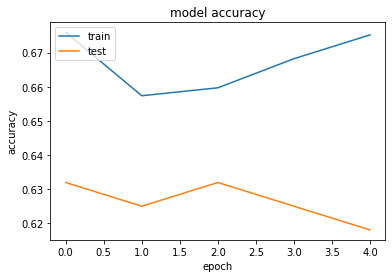

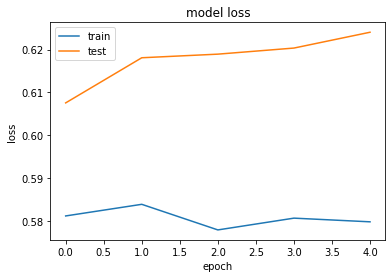

In [48]:
from keras.callbacks import History 

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Make a prediction

In [ ]:
# This is a very small set of completed new data to use to make predictions.
prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
padded = pad_sequences(tokenized, padding='post',maxlen=4)

# Supply this data to each of your models and see how it does. 
# You can call the helper function "to_word_label" to map the output of the model to the name of the
# class it was predicted to belong to.


# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
predict_labels  = np_utils.to_categorical(to_numeric_label(prediction_data))
predict = to_word_label(predict_labels)

predictions = model.predict(predict)
print(predictions)



# SOURCES
https://stackoverflow.com/questions/33726361/counting-the-number-of-unique-words-in-a-list
https://www.geeksforgeeks.org/find-length-of-a-string-in-python-4-ways/
https://www.geeksforgeeks.org/python-standard-deviation-of-list/
https://stackoverflow.com/questions/18413456/python-3-3-2-creating-a-list-of-the-length-of-words
https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
https://keras.io/api/preprocessing/timeseries/
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
https://python-data-science.readthedocs.io/en/latest/sl-deeplearning.html
https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
https://stackoverflow.com/questions/47633789/keras-history-not-accessible-for-loss-or-accuracy